## Imports

In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input

## Create DataFrame

In [3]:
SEED = 42
IMG_SIZE = 300  
BATCH_SIZE = 32
np.random.seed(SEED)
data_path = r"C:\Users\HP\Downloads\archive (4).zip\plantvillage dataset\color"

In [3]:
def create_dataframe(data_path):
    filepaths = []
    labels = []
    folds = os.listdir(data_path)
    for fold in folds:
        f_path = os.path.join(data_path, fold)
        imgs = os.listdir(f_path)
        for img in imgs:
            filepaths.append(os.path.join(f_path, img))
            labels.append(fold)
    return pd.DataFrame({'Filepaths': filepaths, 'Labels': labels})

df = create_dataframe(data_path)
print(f"Total images before cleaning: {len(df)}")

Total images before cleaning: 54305


## Delete samll classes less than 3 pictures 

In [6]:
class_counts = df['Labels'].value_counts()
valid_classes = class_counts[class_counts >= 3].index
df_filtered = df[df['Labels'].isin(valid_classes)].copy()
print(f"Total images after removing small classes: {len(df_filtered)}")
print(f"Number of classes after cleaning: {len(valid_classes)}")

Total images after removing small classes: 54305
Number of classes after cleaning: 38


## Label Encoder

In [7]:
label_encoder = LabelEncoder()
label_encoder.fit(df_filtered['Labels'])
num_classes = len(label_encoder.classes_)
print(f"Number of classes: {num_classes}")

Number of classes: 38


## Data splitting (Train / Validation / Test)

In [8]:
X = df_filtered['Filepaths'].values
y = df_filtered['Labels'].values 


X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)


X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=SEED, stratify=y_train_val
)

print(f"Train: {len(X_train)} | Validation: {len(X_val)} | Test: {len(X_test)}")

Train: 34755 | Validation: 8689 | Test: 10861


## Setting up ImageDataGenerators

In [9]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)
valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

## Creating Data Generators

In [10]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'Filepaths': X_train, 'Labels': y_train}),
    x_col='Filepaths',
    y_col='Labels',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'Filepaths': X_val, 'Labels': y_val}),
    x_col='Filepaths',
    y_col='Labels',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'Filepaths': X_test, 'Labels': y_test}),
    x_col='Filepaths',
    y_col='Labels',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 34755 validated image filenames belonging to 38 classes.
Found 8689 validated image filenames belonging to 38 classes.
Found 10861 validated image filenames belonging to 38 classes.


## EfficientNetB3

### Importing libraries

In [12]:
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers
from tensorflow.keras import Model
import tensorflow as tf

### Setting up an EfficientNetB3 model with transfer learning

### Setting up callbacks

In [13]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    'best_efficientnetb3.keras',
    monitor='val_loss',
    save_best_only=True
)

### Build Model

In [14]:
base_model = EfficientNetB3(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    pooling="avg"
)

base_model.trainable = False

inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)

x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = Model(inputs, outputs)


### Compile the model

In [15]:
LEARNING_RATE = 0.0005 
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

### Training the model on the data

In [42]:
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=15,      
    callbacks=[early_stopping, checkpoint],
    verbose=1
)


Epoch 1/15
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 3221s 3s/step - accuracy: 0.7843 - loss: 0.7849 - val_accuracy: 0.9135 - val_loss: 0.3052
Epoch 2/15
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 2582s 2s/step - accuracy: 0.9023 - loss: 0.3106 - val_accuracy: 0.9391 - val_loss: 0.2028
Epoch 3/15
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 2542s 2s/step - accuracy: 0.9237 - loss: 0.2398 - val_accuracy: 0.9418 - val_loss: 0.1768
Epoch 4/15
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 2573s 2s/step - accuracy: 0.9343 - loss: 0.2045 - val_accuracy: 0.9495 - val_loss: 0.1450
Epoch 5/15
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 2620s 2s/step - accuracy: 0.9378 - loss: 0.1871 - val_accuracy: 0.9553 - val_loss: 0.1348
Epoch 6/15
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 2548s 2s/step - accuracy: 0.9447 - loss: 0.1672 - val_accuracy: 0.9594 - val_loss: 0.1170
Epoch 7/15
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 3048s 3s/step - accuracy: 0.9477 - loss: 0.1586 - val_accuracy: 0.9625 - val_loss: 0.1144
Epoch 8/15
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 3404s 3s/step - accuracy: 0.9503 -

### Load best model After Head Training

In [16]:
from tensorflow.keras.models import load_model
best_model = load_model("best_efficientnetb3.keras")

### Plot Accuracy and Loss Curves (After Head Training)

#### Accuracy

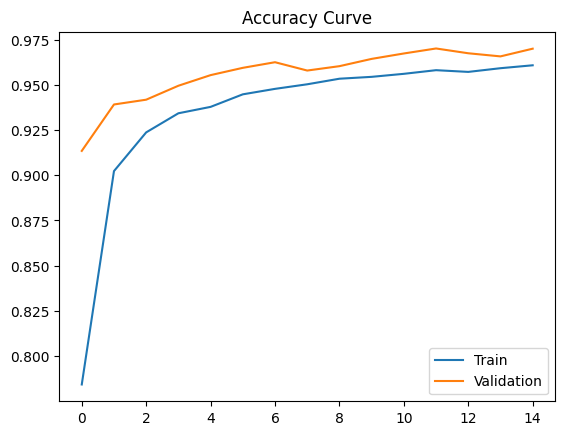

In [48]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Accuracy Curve")
plt.legend(["Train", "Validation"])
plt.show()

#### Loss

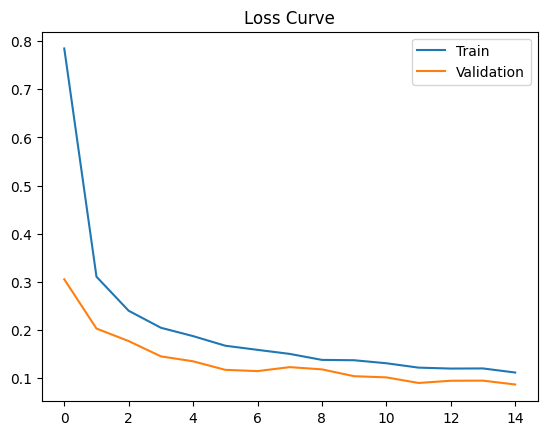

In [49]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Loss Curve")
plt.legend(["Train", "Validation"])
plt.show()